In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ssd_utils
import ssd_view
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import time
import joblib
from joblib import parallel_backend
import pandas as pd
from scipy.linalg import svd
import os
os.environ['OMP_NUM_THREADS'] = '3'


In [3]:
data2020 = ssd_utils.get_all_data_2020(norm = False, itp = True)
data2019 = ssd_utils.get_all_data_2019(norm = False, itp = True)

In [13]:
data2020img = ssd_view.parse_img(data2020)
data2019img = ssd_view.parse_img(data2019)

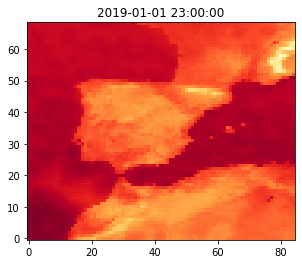

In [3]:
data2019df = ssd_utils.interpolate_1hour(ssd_utils.read_data_2019())
ssd_view.create_animation_pca(data2019df, 300, 0, 24)

# Reducción de Dimensionalidad

In [5]:
data = data2020 - np.mean(data2020) # Datos originales insesgados
cov = np.matmul(data.T, data) # Matriz de covarianzas
    
_, s, _ = svd(cov)

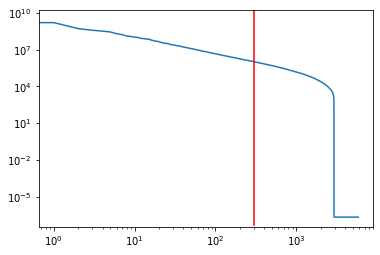

In [13]:
plt.yscale('log')
plt.xscale('log')
plt.plot(s[:-5])
plt.axvline(x=300, ymin=10.**-2, ymax=10.**1, color = "red")

In [29]:
proves = [j for j in range(100, 500, 100)]
ssd_utils.pca_metric_test(data2019, data2020, proves)

N.Componentes = 100; --->   Varianza Retenida = 91.478; %  MSE = 16.406;   R2 = 89.266 %  Reducción Total = 98.295 % ---   Time --> 12.90 s *** Error en train: 7.272
N.Componentes = 200; --->   Varianza Retenida = 94.541; %  MSE = 11.314;   R2 = 92.598 %  Reducción Total = 96.590 % ---   Time --> 14.68 s *** Error en train: 4.643
N.Componentes = 300; --->   Varianza Retenida = 96.017; %  MSE = 8.904;   R2 = 94.174 %  Reducción Total = 94.885 % ---   Time --> 17.20 s *** Error en train: 3.374
N.Componentes = 400; --->   Varianza Retenida = 96.940; %  MSE = 7.394;   R2 = 95.162 %  Reducción Total = 93.180 % ---   Time --> 18.90 s *** Error en train: 2.586

Tiempo --> 82.94 s


N.Componentes = 300; --->   MSE = 8.904;   R2 = 94.174 %  Reducción Total = 94.885 % ---   Time --> 29.36 s *** Error en train: 3.374

Tiempo --> 29.36 s


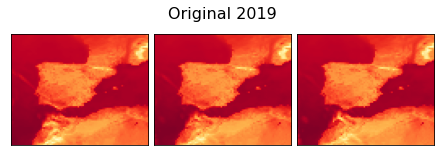

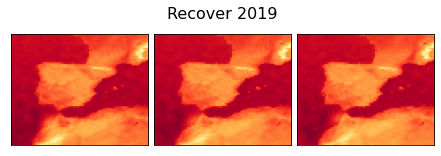

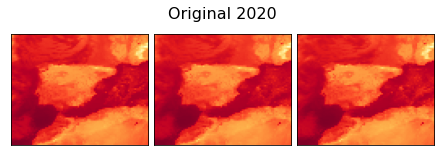

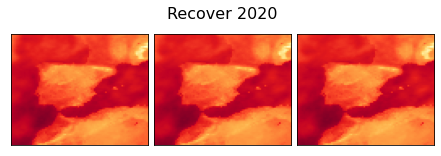

In [18]:
ssd_utils.pca_view(data2019, data2020, ncomp = 300)

In [4]:
def grid_search_showdata(f_name):
    print("Nombre del fichero: " + f_name)
    saved = joblib.load(f_name)
    df_cv_estimator = pd.DataFrame.from_dict(saved.cv_results_)
    print("Mejor Alpha: " + str(saved.best_params_))
    plt.xscale('log')
    plt.plot(df_cv_estimator['param_regressor__mlp__alpha'], -df_cv_estimator['mean_test_score'])
    plt.show()
    print()
    
    
    estimator = saved.best_estimator_
    
    plt.plot(estimator.regressor_.named_steps['mlp'].loss_curve_)
    plt.yscale('log')
    
    recover2019 = estimator.predict(data2019)
    print("ECM en train (2019): " + str(mean_squared_error(recover2019, data2019)))
    recover2020 = estimator.predict(data2020)
    print("ECM en test (2020): " + str(mean_squared_error(recover2020, data2020)))
    

Nombre del fichero: linear(300)_100patience.joblib
Mejor Alpha: {'regressor__mlp__alpha': 10.0}


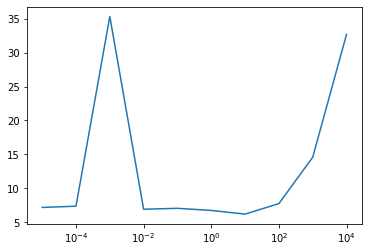


ECM en train (2019): 3.535487754663135
ECM en test (2020): 9.2347020720032


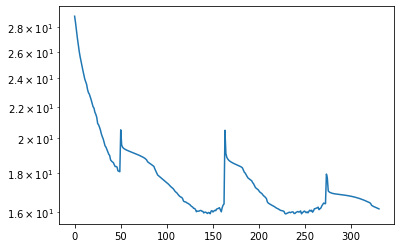

In [24]:
f_lin = 'stored_objs/linear(300)_100patience.joblib'
grid_search_showdata(f_lin)

Nombre del fichero: multilayer(1000,300,1000)relu_200patience_scale.joblib
Mejor Alpha: {'regressor__mlp__alpha': 100.0}


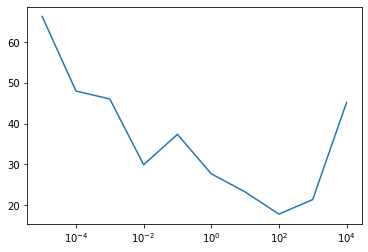


ECM en train (2019): 7.811914706487627
ECM en test (2020): 20.4881704332371


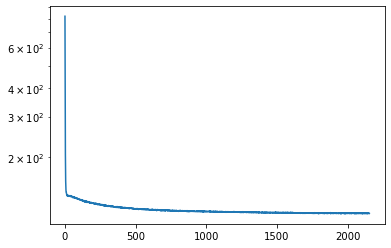

In [5]:
f_multi =  'stored_objs/multilayer(1000,300,1000)relu_200patience_scale.joblib'
grid_search_showdata(f_multi)

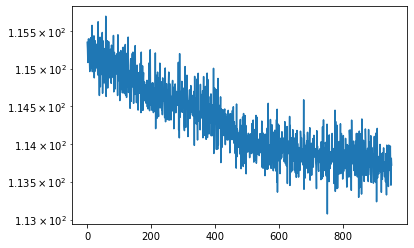

In [12]:
f_multi =  'stored_objs/multilayer(1000,300,1000)relu_200patience.joblib'
saved = joblib.load(f_multi)
estimator = saved.best_estimator_
    
# plt.figure(figsize = (20,6))
plt.plot(estimator.regressor_.named_steps['mlp'].loss_curve_[1200:2200])
plt.yscale('log')

# Predicción de la evolución temporal

In [3]:
data_orig_2020 = ssd_utils.extract_data(ssd_utils.read_data_2020())
data_orig_2019 = ssd_utils.extract_data(ssd_utils.read_data_2019())

In [4]:
pca = PCA(n_components = 300, random_state = 1)
reduced_data_2019 = pca.fit_transform(data_orig_2019)
reduced_data_2020 = pca.transform(data_orig_2020)

In [5]:
data_fwd_o_2019 = data_orig_2019[1:, :]
data_bck_o_2019 = data_orig_2019[:-1, :]
data_fwd_o_2020 = data_orig_2020[1:, :]
data_bck_o_2020 = data_orig_2020[:-1, :]

In [6]:
data_fwd_r_2019 = reduced_data_2019[1:, :]
data_bck_r_2019 = reduced_data_2019[:-1, :]
data_fwd_r_2020 = reduced_data_2020[1:, :]
data_bck_r_2020 = reduced_data_2020[:-1, :]

In [7]:
print("Modelo de persistencia sobre datos originales (2019): " + str(mean_squared_error(data_bck_o_2019, data_fwd_o_2019)))
print("Modelo de persistencia sobre datos reducidos (2019): " + str(mean_squared_error(pca.inverse_transform(data_bck_r_2019), data_fwd_o_2019)))
print("Modelo de persistencia sobre datos originales (2020): " + str(mean_squared_error(data_bck_o_2020, data_fwd_o_2020)))
print("Modelo de persistencia sobre datos reducidos (2020): " + str(mean_squared_error(pca.inverse_transform(data_bck_r_2020), data_fwd_o_2020)))

Modelo de persistencia sobre datos originales (2019): 92.81508841151982
Modelo de persistencia sobre datos reducidos (2019): 83.22489899444246
Modelo de persistencia sobre datos originales (2020): 92.53683577972434
Modelo de persistencia sobre datos reducidos (2020): 81.25210175021917


## Predictor Lineal [Ridge]

In [7]:
f_name_ridge_o = 'stored_objs/ts_results_ridge_2019.joblib'
saved_ridge_o = joblib.load(f_name_ridge_o)

f_name_ridge_r = 'stored_objs/tsred_results_ridge_2019.joblib'
saved_ridge_r = joblib.load(f_name_ridge_r)

ridge_estimator_o = saved_ridge_o.best_estimator_
ridge_estimator_r = saved_ridge_r.best_estimator_

In [8]:
print("Modelo de persistencia sobre datos originales (2019): " + str(mean_squared_error(data_bck_o_2019, data_fwd_o_2019)))
print("Error en train ridge original (2019): " + str(mean_squared_error(ridge_estimator_o.predict(data_bck_o_2019), data_fwd_o_2019)))
print("Error en test ridge original (2020): " + str(mean_squared_error(ridge_estimator_o.predict(data_bck_o_2020), data_fwd_o_2020)))

Modelo de persistencia sobre datos originales (2019): 92.81508841151982
Error en train ridge original (2019): 44.82986891190772
Error en test ridge original (2020): 51.455471480734396


In [9]:
print("Modelo de persistencia sobre datos reducidos (2019): " + str(mean_squared_error(pca.inverse_transform(data_bck_r_2019), data_fwd_o_2019)))
print("Error en train ridge reducidos (2019): " + str(mean_squared_error(pca.inverse_transform(ridge_estimator_r.predict(data_bck_r_2019)), data_fwd_o_2019)))
print("Error en test ridge reducidos (2020): " + str(mean_squared_error(pca.inverse_transform(ridge_estimator_r.predict(data_bck_r_2020)), data_fwd_o_2020)))

Modelo de persistencia sobre datos reducidos (2019): 83.22489899444246
Error en train ridge reducidos (2019): 46.464125061058894
Error en test ridge reducidos (2020): 53.79858606553696


## Predictor Neuronal [MLP (1000, 1000)]

In [9]:
f_name_mlp_o = 'stored_objs/ts_results_mlp_2019_v3.joblib'
saved_mlp_o = joblib.load(f_name_mlp_o)

f_name_mlp_r = 'stored_objs/tsred_results_mlp_2019_v3.joblib'
saved_mlp_r = joblib.load(f_name_mlp_r)

mlp_estimator_o = saved_mlp_o.best_estimator_
mlp_estimator_r = saved_mlp_r.best_estimator_

In [13]:
print("Modelo de persistencia sobre datos originales (2019): " + str(mean_squared_error(data_bck_o_2019, data_fwd_o_2019)))
print("Error en train mlp original (2019): " + str(mean_squared_error(mlp_estimator_o.predict(data_bck_o_2019), data_fwd_o_2019)))
print("Error en test mlp original (2020): " + str(mean_squared_error(mlp_estimator_o.predict(data_bck_o_2020), data_fwd_o_2020)))

Modelo de persistencia sobre datos originales (2019): 92.81508841151982
Error en train mlp original (2019): 52.70032253206342
Error en test mlp original (2020): 58.44754563465113


In [14]:
print("Modelo de persistencia sobre datos reducidos (2019): " + str(mean_squared_error(pca.inverse_transform(data_bck_r_2019), data_fwd_o_2019)))
print("Error en train mlp reducidos (2019): " + str(mean_squared_error(pca.inverse_transform(mlp_estimator_r.predict(data_bck_r_2019)), data_fwd_o_2019)))
print("Error en test mlp reducidos (2020): " + str(mean_squared_error(pca.inverse_transform(mlp_estimator_r.predict(data_bck_r_2020)), data_fwd_o_2020)))

Modelo de persistencia sobre datos reducidos (2019): 83.22489899444246
Error en train mlp reducidos (2019): 23.189334422737147
Error en test mlp reducidos (2020): 49.34977271431635
